# Simulating future prices using Monte Carlo Methods

In [1]:
import pandas as pd 
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

In [2]:
class Data():
    def __init__(self, ticker, start=None, end=None):
        self.ticker = ticker
        if start == None:
            start = '2020-01-01' # default start date
        if end == None:
            end = datetime.today().strftime('%Y-%m-%d') # datetime.today().strftime('%Y-%m-%d')
        self.start = start
        self.end = end
        
        data = yf.Ticker(self.ticker)
        self.df = data.history(start=self.start, end=self.end, rounding=True)
        self.df['return'] = (self.df['Close'] - self.df['Open']) / self.df['Open']
    
    def get_data(self):
        print(f'TICKER: {self.ticker}')
        
        return self.df
    
    def plot_data(self):
        fig = plt.figure()
        plt.plot(self.df['Close'])
        fig.autofmt_xdate()
        
        return
    
    
    def get_mu_std(self):
    
        self.mu = (self.df.iloc[-1]['Close'] - self.df.iloc[0]['Close']) / self.df.iloc[0]['Close']
        self.std = self.df['return'].std()

        return (self.mu, self.std)
    
    def get_price(self):
        print()
        print(f"TICKER: {self.ticker}")
        print(f"Current price: ${self.df.iloc[-1]['Close']} ({self.end})")
        print(f"Initial price: ${self.df.iloc[0]['Close']} ({self.start})")
        print("---------------------------------------------")
        
    def plot_ts(self):
        print()
        print(f"TICKER: {self.ticker}")
        print(f"Current price: ${self.df.iloc[-1]['Close']} ({self.end})")
        print(f"Initial price: ${self.df.iloc[0]['Close']} ({self.start})")
        print("---------------------------------------------")
        fig, axes = plt.subplots(1, 2, figsize=(12,4))

        # plot time series
        axes[0].plot(self.df['Close'])
        axes[0].set_xlabel("Years")
        axes[0].set_ylabel("Price in USD")
        axes[0].set_title(f"Current time series of {self.ticker}")
        fig.autofmt_xdate()

        # plot histogram of returns
        axes[1].hist(self.df['return'], bins=20)
        axes[1].set_xlabel("Returns")
        axes[1].set_ylabel("Frequency")
        axes[1].set_title("Histogram of current returns")
        # Density = True
        locs = axes[1].get_yticks() 
        axes[1].set_yticks(locs);
        axes[1].set_yticklabels(np.round(locs/len(self.df['return']),3));
        
        total_time = len(self.df)
        print(f"From {str(self.df.index[0])[:10]} to {str(self.df.index[-1])[:10]}:")
        print(f"    Average return in {total_time} market days is {round(100*self.get_mu_std()[0], 3)}%. \n    Standard deviation of returns during this time period is {round(self.get_mu_std()[1], 3)}.")

        return


TICKER: NVDA
Current price: $158.27 (2022-11-29)
Initial price: $59.79 (2020-01-01)
---------------------------------------------
From 2020-01-02 to 2022-11-28:
    Average return in 733 market days is 164.71%. 
    Standard deviation of returns during this time period is 0.028.


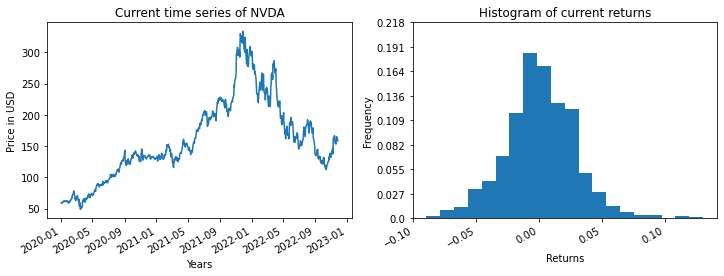

In [3]:
PYPL = Data('NVDA')
PYPL.plot_ts()

In [4]:
class simulations(Data):
    def __init__(self, ticker, start=None, end=None, time=None, N=5000):
        super(simulations, self).__init__(ticker, start, end) 
        if time == None:
            time = 252
        self.time = time
        self.N = N
 
    def MC_Simulation(self):
    
        mu, sigma = self.get_mu_std()
        S0 = self.df.iloc[-1]['Close']
        muS = mu/len(self.df)

        final_points = []
        returns = []

        print()
        print("---------------------------------------------")
        print(f"Simulating {self.time} days into the future {self.N} times...")

        # MC simulate N times
        for sim in range(self.N):
            S_pos = [S0]
            Z = np.random.normal(0,1, size = self.time)

            for t in range(0, self.time):
                S_pos.append(S_pos[t] + S_pos[t]*(muS + sigma*Z[t]))
            final_points.append(S_pos[-1])

        # Descriptive statistics for ending points
        average = np.round(np.mean(final_points), 2)
        median = np.round(np.percentile(final_points, 50), 2)
        twentyfive = np.round(np.percentile(final_points, 25), 2)
        seventyfive = np.round(np.percentile(final_points, 75), 2)

        print()
        print(f"Average ending price: ${average}  ({round(100*(average-S0)/S0, 2)}%)")
        print(f"Median ending price: ${median}  ({round(100*(median-S0)/S0, 2)}%)")
        print(f"25th percentile of ending price: ${twentyfive}  ({round(100*(twentyfive-S0)/S0, 2)}%)")
        print(f"75th percentile of ending price: ${seventyfive}  ({round(100*(seventyfive-S0)/S0, 2)}%)")

        self.final_points = final_points
        
        return 
    
    def plot_sim(self):
        self.MC_Simulation()
        fig, axes = plt.subplots(1, 2, figsize=(12,4))
        fig.suptitle(f"Simulation Results: {self.ticker} ({self.time} days)", fontsize=18, y = 1)

        # plot histogram
        axes[0].hist(self.final_points, bins=20)
        axes[0].set_xlabel("Ending Price")
        axes[0].set_ylabel("Frequency")
        axes[0].set_title("Histogram of future prices")
        # show density of histogram
        locs = axes[0].get_yticks() 
        axes[0].set_yticks(locs);
        axes[0].set_yticklabels(np.round(locs/len(self.final_points),3));

        # plot boxplot
        sns.boxplot(data=self.final_points, orient="h", ax=axes[1])
        plt.title("Boxplot of future prices")
        plt.xlabel("Price in USD")

        return

### Wrapper functions

In [5]:
def simulate(ticker, start=None, end=None, time=None):
    """
    Wrapper function: simulate and graph results given parameters
    
    Parameters
    ----------
    ticker : str
        name of ticker (e.g. "AAPL")
    start : str
        valid date indicating beginning of historical data ('yyyy-mm-dd'), defaulted to '2020-01-01'
    end : str
        valid date indicating ending of historical data ('yyyy-mm-dd'), defaulted to most recent market day
    time : int
        number of days user wishes to simulate into the future, defaulted to 252 (one trading year)
    """
    stock = simulations(ticker, start=start, end=end, time=time)
    stock.plot_ts()
    stock.plot_sim()
    
    return

In [6]:
def compare_times(ticker, time1, time2, start=None, end=None):
    """
    Compares predicted future performance of the same stock for two time frames. 
    
    Parameters
    ----------
    ticker : str
        name of ticker (e.g. "AAPL")
    time1 : int
        first number of days user wishes to simulate into the future (252 is one trading year)
    time2 : int
        second number of days user wishes to simulate into the future, different from time1
    start : str
        valid date indicating beginning of historical data ('yyyy-mm-dd'), defaulted to '2020-01-01'
    end : str
        valid date indicating ending of historical data ('yyyy-mm-dd'), defaulted to most recent market day
    """
    stock = simulations(ticker, time=time1, start=start, end=end)
    stock.plot_ts()
    
    #first
    stock.plot_sim()
    
    #second
    stock = simulations(ticker, time=time2, start=start, end=end)
    stock.plot_sim()
    
    return

In [7]:
def compare_stocks(ticker1, ticker2, time=None, start=None, end=None):
    """
    Comparing simulated prices for two different stocks, ticker1 and ticker2.
    Good for comparing correlated stocks (e.g. PEP and KO).
    
    Parameters
    ----------
    ticker1 : str
        name of first ticker (e.g. "AAPL")
    ticker2 : str
        name of second ticker
    time : int
        number of days user wishes to simulate into the future (252 is one trading year)
    start : str
        valid date indicating beginning of historical data ('yyyy-mm-dd'), defaulted to '2020-01-01'
    end : str
        valid date indicating ending of historical data ('yyyy-mm-dd'), defaulted to most recent market day
    """
    #first stock
    stock1 = simulations(ticker1, time=time, start=start, end=end)
    stock1.get_price()
    stock1.plot_sim()
    
    print()
    print("-----------------------------------------------------------------------------")
    
    #second stock
    stock2 = simulations(ticker2, time=time, start=start, end=end)
    stock2.get_price()
    stock2.plot_sim()
    
    return

# Simulations


TICKER: PYPL
Current price: $79.93 (2022-11-29)
Initial price: $110.75 (2020-01-01)
---------------------------------------------
From 2020-01-02 to 2022-11-28:
    Average return in 733 market days is -27.828%. 
    Standard deviation of returns during this time period is 0.024.

---------------------------------------------
Simulating 252 days into the future 5000 times...

Average ending price: $73.28  (-8.32%)
Median ending price: $68.3  (-14.55%)
25th percentile of ending price: $52.59  (-34.2%)
75th percentile of ending price: $88.39  (10.58%)


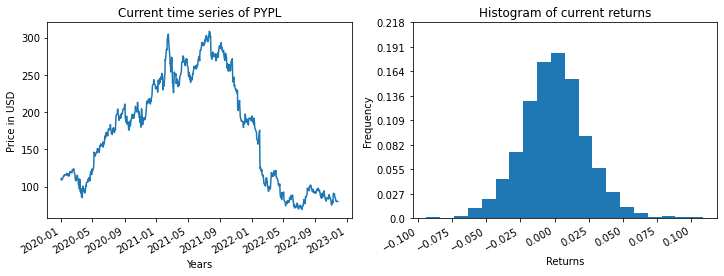

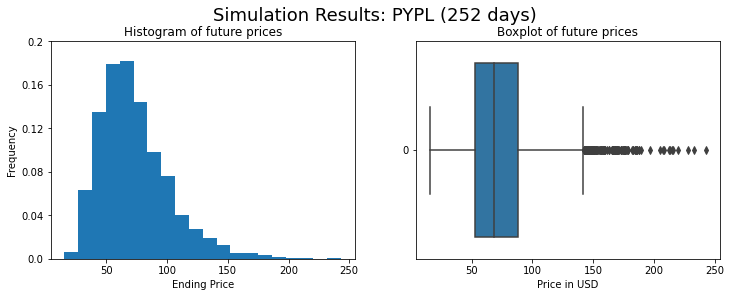

In [8]:
# args: ticker | kwargs: start='2020-01-01', end=today, time=252
simulate('PYPL')


TICKER: SQ
Current price: $61.37 (2022-11-29)
Initial price: $63.83 (2020-01-01)
---------------------------------------------
From 2020-01-02 to 2022-11-28:
    Average return in 733 market days is -3.854%. 
    Standard deviation of returns during this time period is 0.037.

---------------------------------------------
Simulating 252 days into the future 5000 times...

Average ending price: $60.73  (-1.04%)
Median ending price: $50.83  (-17.17%)
25th percentile of ending price: $34.07  (-44.48%)
75th percentile of ending price: $75.92  (23.71%)

---------------------------------------------
Simulating 500 days into the future 5000 times...

Average ending price: $59.88  (-2.43%)
Median ending price: $43.29  (-29.46%)
25th percentile of ending price: $24.36  (-60.31%)
75th percentile of ending price: $75.54  (23.09%)


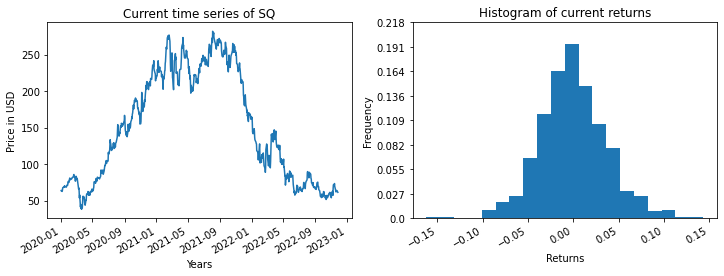

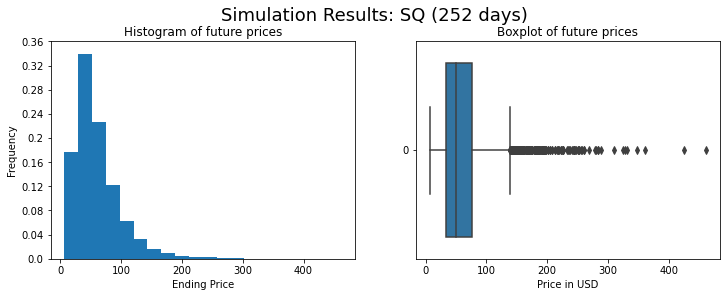

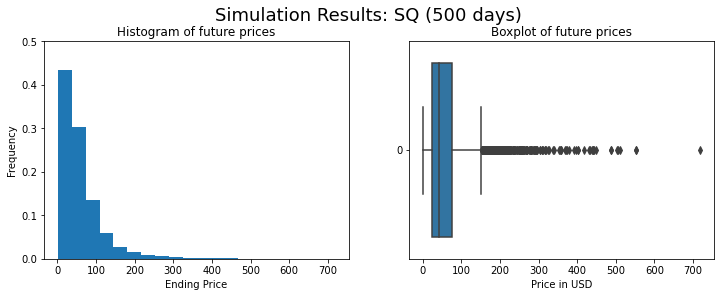

In [9]:
# args: ticker, time1, time2 | kwargs: start='2020-01-01', end=today, time=252
compare_times('SQ', time1=252, time2=500)


TICKER: SPY
Current price: $395.91 (2022-11-29)
Initial price: $311.12 (2020-01-01)
---------------------------------------------

---------------------------------------------
Simulating 252 days into the future 5000 times...

Average ending price: $434.74  (9.81%)
Median ending price: $428.85  (8.32%)
25th percentile of ending price: $383.38  (-3.16%)
75th percentile of ending price: $480.7  (21.42%)

-----------------------------------------------------------------------------

TICKER: VOO
Current price: $363.95 (2022-11-29)
Initial price: $285.61 (2020-01-01)
---------------------------------------------

---------------------------------------------
Simulating 252 days into the future 5000 times...

Average ending price: $399.25  (9.7%)
Median ending price: $394.23  (8.32%)
25th percentile of ending price: $350.94  (-3.57%)
75th percentile of ending price: $440.83  (21.12%)


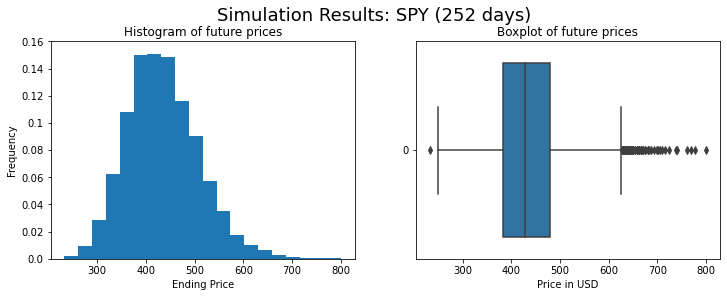

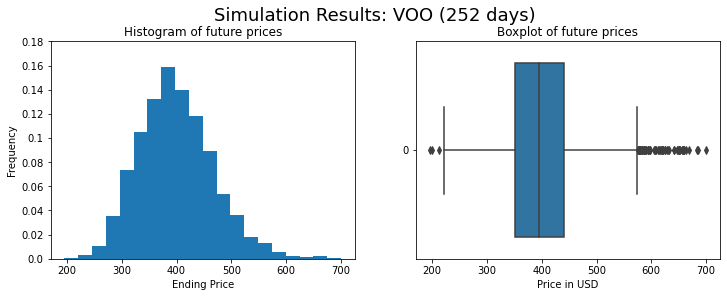

In [10]:
# args: ticker 1, ticker 2 | kwargs: start='2020-01-01', end=today, time=252
compare_stocks("SPY", "VOO")